## Import libraries

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts

## Question 2： Unit roots

In [95]:
nSamples = 5000  # number of sequences
nSteps = 100   # length

a = np.zeros([nSamples, nSteps])

np.random.seed(123456)  # set the random seed
ϵ = np.random.normal(0, 1, a.shape)   # random matrix with standard normal distribution

### Simulation (data generating process)

In [96]:
for i in range(nSamples):
    for j in range(1, nSteps):
        a[i][j] = a[i][j-1] + ϵ[i][j]  # the initial value is 0

In [97]:
### create the zero-coloum for storing the results from model1 and model2
results1 = np.zeros(nSamples)
results2 = np.zeros(nSamples)

### the formula for t-ratios as follows:

$$t-ratios = \frac{\hat{\phi}-1}{standard\, error}$$

we can get the standard error by 
```sm.OLS(y,x).fit.bse```

### do the regression

In [98]:
for i in range(nSamples):
    x = a[i][:-1]  # the value of explanatory variables X(t-1)
    X = sm.add_constant(x)  # the second model asks adding a constant
    y = a[i][1:]
    
    model1 = sm.OLS(y, x)
    model2 = sm.OLS(y, X)
    
    model1 = model1.fit()
    model2 = model2.fit()
    
    ### calculate the t-values and store them
    results1[i] = (model1.params - 1) / model1.bse
    results2[i] = (model2.params[1] - 1) / model2.bse[1]  # when index == 0, it will get the t-value of constant

### get the percentile

In [110]:
### for model1--without the constant
print("5% percentile of the t-ratios in case 1 is {}".format(round(np.percentile(results1, 5), 4)))

### for model2--with the constant
print("5% percentile of the t-ratios in case 2 is {}".format(round(np.percentile(results2, 5), 4)))

5% percentile of the t-ratios in case 1 is -1.8956
5% percentile of the t-ratios in case 2 is -2.9288


#### It can be found that the percentile of two models are about -1.95 and -2.89. The reason that the values vary is the variance of simulation. And actually we can check the variance as following:

In [97]:
print(np.std(results1))
print(np.std(results2))

0.9775213586690245
0.8513013235130988


## Question 3: Interest rate data:

#### import and read the data

In [5]:
df = pd.read_excel("quarterly.xlsx")
df.head()

,DATE,FFR,Tbill,Tb1yr,r5,r10,PPINSA,Finished,CPI,CPICORE,M1NSA,M2SA,M2NSA,Unemp,IndProd,RGDP,Potent,Deflator,Curr
0,1960Q1,3.93,3.87,4.57,4.64,4.49,31.67,33.20,29.40,18.92,140.53,896.1,299.40,5.13,23.93,2845.3,2824.2,18.521,31.830
1,1960Q2,3.70,2.99,3.87,4.30,4.26,31.73,33.40,29.57,19.00,138.40,903.3,300.03,5.23,23.41,2832.0,2851.2,18.579,31.862
2,1960Q3,2.94,2.36,3.07,3.67,3.83,31.63,33.43,29.59,19.07,139.60,919.4,305.50,5.53,23.02,2836.6,2878.7,18.648,32.217
3,1960Q4,2.30,2.31,2.99,3.75,3.89,31.70,33.67,29.78,19.14,142.67,932.8,312.30,6.27,22.47,2800.2,2906.7,18.700,32.624
4,1961Q1,2.00,2.35,2.87,3.64,3.79,31.80,33.63,29.84,19.17,142.23,948.9,317.10,6.80,22.13,2816.9,2934.8,18.743,32.073


#### create the spread series: 

$$s_t = Tbill_t - r10_t$$

In [20]:
spread = df.Tbill - df.r10
df['spread'] = spread  # append a new column in dataframe 

#### plot the series

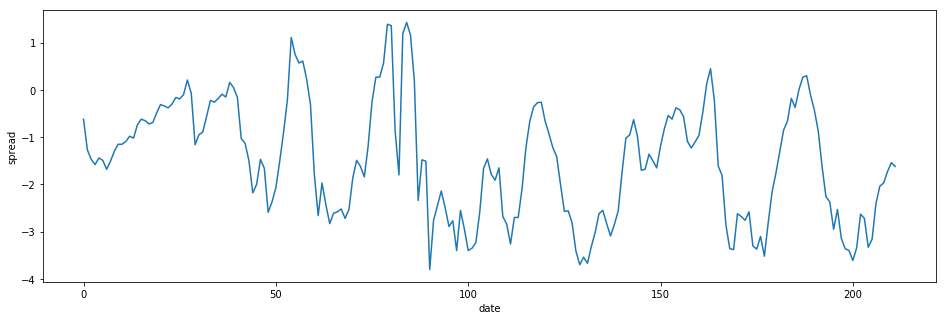

In [39]:
plt.figure(figsize=(16, 5))
plt.xlabel('date')
plt.ylabel('spread')
plt.plot(df.spread)
plt.show()

#### plot the acf and pacf

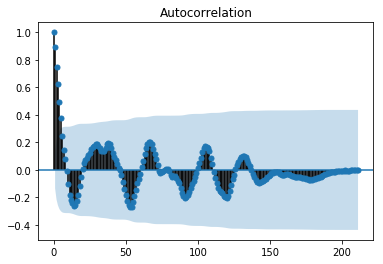

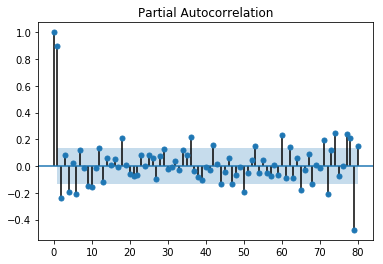

In [52]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(df.spread)
plot_pacf(df.spread, lags=80)  # creates a 2D plot of the partial autocorrelation for the first 80 lags.

plt.show()

#### compute the first fifth acf values

In [51]:
print(ts.acf(df.series, nlags=5)[1:])

[0.88939947 0.74406438 0.62605053 0.49646506 0.37675435]


From the above output, we can find that $$\rho_1 ≈ 0.8894, \rho_2 ≈ 0.7441$$ which is consistent with the values in the question.

### 1. perform the ADF test on the spread with 8 lags

In [133]:
result1 = ts.adfuller(df.spread, 8, regression="c", autolag='AIC') 

### in argument 'regression':
# * 'c' : constant only (default)
# * 'ct' : constant and trend
# * 'ctt' : constant, and linear and quadratic trend
# * 'nc' : no constant, no trend

### in argument 'autolag':
# can be AIC(default) or BIC or t-value

In [134]:
print('ADF Statistic: %f' % result1[0])
print('p-value: %f' % result1[1])
print('Critical Values:')
for key, value in result1[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -4.267685
p-value: 0.000505
Critical Values:
	1%: -3.463
	5%: -2.876
	10%: -2.574


The null hypothesis of ADF test is that the series has unit root. In this case, we got a p-value is 0.0005, which means reject the null hypothesis. The spread series is stationary.

### 2. perform the ADF test on r10 with 5 lags

In [135]:
result2 = ts.adfuller(df.r10, 5)

In [136]:
print('ADF Statistic: %f' % result2[0])
print('p-value: %f' % result2[1])
print('Critical Values:')
for key, value in result2[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.033189
p-value: 0.740968
Critical Values:
	1%: -3.462
	5%: -2.876
	10%: -2.574


### do the ADF test for first-order difference series of r10

In [140]:
### create the differene series
diff_r10 = np.zeros(len(df.r10)-1)
for i in range(len(df.r10)-1):
    diff_r10[i] = df.r10[i+1] - df.r10[i]

In [141]:
### ADF results
result21 = ts.adfuller(diff_r10, 5)
print('ADF Statistic: %f' % result21[0])
print('p-value: %f' % result21[1])
print('Critical Values:')
for key, value in result21[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -7.021281
p-value: 0.000000
Critical Values:
	1%: -3.462
	5%: -2.876
	10%: -2.574


From the above results, it's obvious that r10 is a first-order difference stationary series.

### 3. perform the ADF test on T-bill with 7 lags

In [138]:
result3 = ts.adfuller(df.Tbill, 7)

In [142]:
print('ADF Statistic: %f' % result3[0])
print('p-value: %f' % result3[1])
print('Critical Values:')
for key, value in result3[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.613035
p-value: 0.476383
Critical Values:
	1%: -3.463
	5%: -2.876
	10%: -2.574


### do the ADF test for first-order difference series of T-bill

In [143]:
### create the differene series
diff_Tbill = np.zeros(len(df.Tbill)-1)
for i in range(len(df.Tbill)-1):
    diff_Tbill[i] = df.Tbill[i+1] - df.Tbill[i]

In [146]:
### ADF results
result31 = ts.adfuller(diff_Tbill, 7) 
print('ADF Statistic: %f' % result31[0])
print('p-value: %f' % result31[1])
print('Critical Values:')
for key, value in result31[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -6.340640
p-value: 0.000000
Critical Values:
	1%: -3.463
	5%: -2.876
	10%: -2.574


From the above results, it's obvious that Tbill is a first-order difference stationary series.

## 4. The difference between two I(1) process: T-bill and r10

The above results shows that the spread series is not stationary, though both T-bill and r10 are first-order difference stationary. 
Actually, the difference between two I(1) processes dosen't necessarily to be stationary. These two process can have their own trend and dosen't match to each other, when subtracting them cannot offset these trend.

### 5. perform the ADF test on T-bill with 5 lags

In [145]:
result4 = ts.adfuller(df.Tbill, 5)

In [124]:
print('ADF Statistic: %f' % result4[0])
print('p-value: %f' % result4[1])
print('Critical Values:')
for key, value in result4[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.726677
p-value: 0.069535
Critical Values:
	1%: -3.462
	5%: -2.876
	10%: -2.574


From the above results, it can be found that with 7 AR components, the ADF test for Tbill series recept the null hypothesis, while with 5 AR components, the series reject the null hypothesis at 10% confidence level.

The construction of ADF statistics is in the formula like:
$$ \hat{\tau_u} = \frac{\hat{\phi_1}}{\hat{SE}(\hat{\phi_1})} $$

It is testing whether the estimated value is close to 0 or not. Because we did the transformtion(differencing) at first, and then do the hypothesis testing on the transformed model.

The change of this ratio can result from the change of parameter's estimated value or the standard error.
If the estimated value changed, which means with five lags(or AR components), the estimated valued differs a lot from 0. While with seven lags, this kind of value will close to 0. 

This may relate to the auto-correlation in T-bill sereis, because of serial correlation, the estimated value varies. So we draw the figure of auto-correlation. 

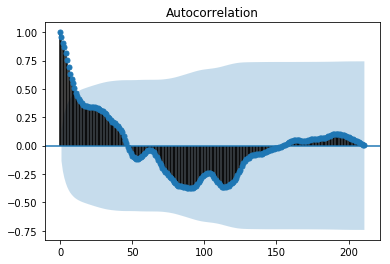

In [151]:
plot_acf(df.Tbill)
plt.show()

It changes irregularly, and shows the self correlation exists.